In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # data visualisation
import datetime as dt # working with time data
import plotly.graph_objs as go # plotly graphical object
import statsmodels.api as sm #time-series analysis for python
import warnings  
import missingno as msno 
from statsmodels.tsa.api import VAR
warnings.filterwarnings('ignore')

c:\Users\asadullahqamar.qamar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\asadullahqamar.qamar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_excel("../Data/gasoline_price_sentiment_pre-processed_7.xlsx", "Sheet1")
# df = pd.read_excel("../Data/gasoline_price_sentiment_pre-processed_30.xlsx", "Sheet1")
# df = pd.read_excel("../Data/gasoline_price_sentiment_pre-processed_365.xlsx", "Sheet1")
horizon = 7

# VAR

In [3]:
buf = df.copy()#reset buf
buf = buf.set_index('Date')
buf.index = pd.DatetimeIndex(buf.index).to_period('D')

### Remove Any Final Missing Values

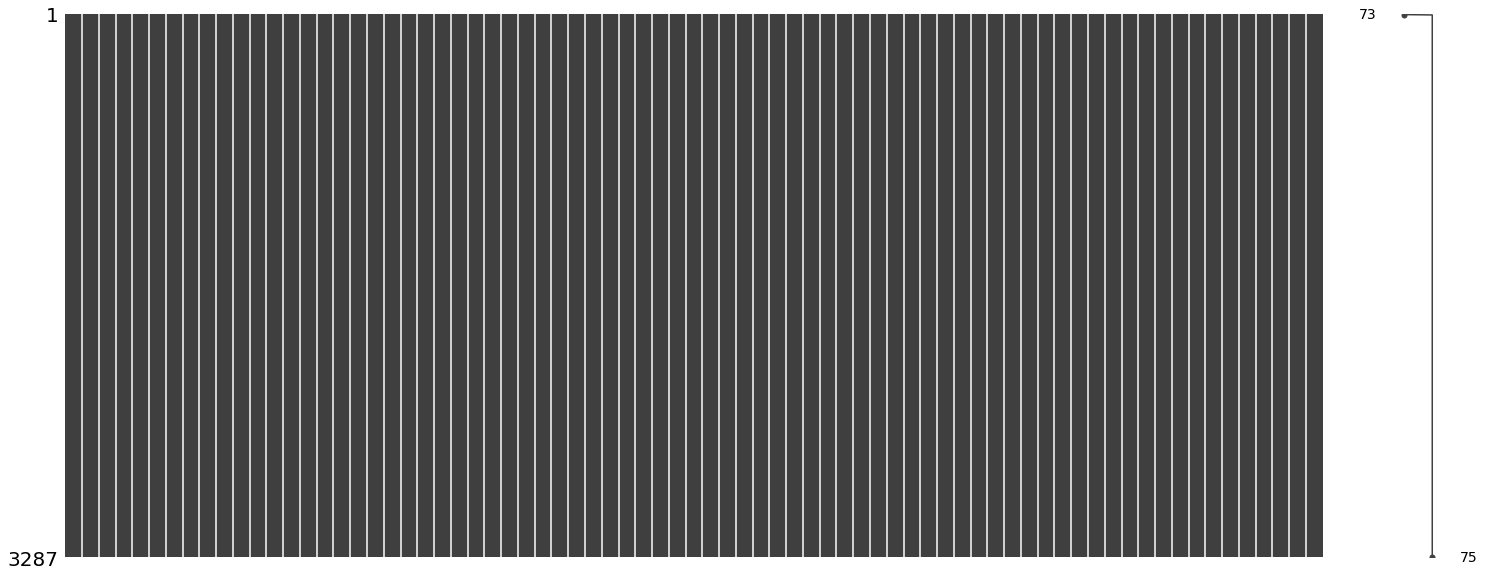

In [4]:
buf_before = buf.copy()
msno.matrix(buf_before)
plt.show()

In [5]:
def checkMissingVal(df):
    i = 0
    for val in buf.isna().sum():
        if(val > 0):
            print(f"Missing value detected in column number {i}")
        i+=1

In [6]:
checkMissingVal(buf)

Missing value detected in column number 72
Missing value detected in column number 73


In [7]:
buf['Holidays'].fillna(0, inplace=True) #Impute missing Holidays as 0
buf = buf[buf['price_lag_7'].isna() == False] #Remove first 7 rows

In [8]:
checkMissingVal(buf)

### Select Features

In [9]:
buf.columns

Index(['Unnamed: 0', 'price', 'popularity', 'general_sentiment',
       'positive_outlook', 'happiness', 'bittersweet', 'confidence', 'disgust',
       'disagreement', 'anxiety', 'gloominess', 'distress', 'violent',
       'unexpectedness', 'timeliness', 'confusion', 'feelingsVsTruth',
       'buyVsSell', 'buyVsSellForecast', 'priceTrend', 'pricePrediction',
       'volatile', 'consumptionCommodity', 'productionCommodity', 'regulatory',
       'supplyDemandBalance', 'supplyDemandBalanceForecast', 'exploration',
       'accidents', 'National_Holiday', 'Weekend', 'Holidays', 'happiness_Log',
       'bittersweet_Log', 'disgust_Log', 'disagreement_Log', 'anxiety_Log',
       'gloominess_Log', 'distress_Log', 'violent_Log', 'unexpectedness_Log',
       'confusion_Log', 'buyVsSell_sqrt', 'pricePrediction_Log',
       'volatile_Log', 'productionCommodity_Log', 'regulatory_Log',
       'supplyDemandBalance_Log', 'exploration_Log', 'accidents_Log',
       'month-1', 'month-2', 'month-3', 'month

In [10]:
selected_variable_columns = ['price', 'happiness_Log', 'bittersweet_Log',
       'disgust_Log', 'disagreement_Log', 'anxiety_Log', 'gloominess_Log',
       'distress_Log', 'violent_Log', 'unexpectedness_Log', 'confusion_Log',
       'buyVsSell_sqrt', 'pricePrediction_Log', 'volatile_Log',
       'productionCommodity_Log', 'regulatory_Log', 'supplyDemandBalance_Log',
       'exploration_Log', 'accidents_Log', 'supplyDemandBalanceForecast', 
       'consumptionCommodity', 'priceTrend', 'buyVsSellForecast', 'feelingsVsTruth',
       'timeliness', 'confidence', 'popularity', 'general_sentiment', 'positive_outlook',
       'price_lag_7', 'price_rm', 'price_ewm', 'month-1', 'month-2', 
       'month-3', 'month-4', 'month-5', 'month-6', 'month-7', 'month-8', 
       'month-9', 'month-10', 'month-11', 'month-12', 'dayofweek-0',
       'dayofweek-1', 'dayofweek-2', 'dayofweek-3', 'dayofweek-4',
       'dayofweek-5', 'dayofweek-6', 'weekend', 'sunday']

#We are taking the transformed columns and the derived features

## Train Test Split

In [11]:
train_size = int(len(buf) * 0.80)
train_size

2624

In [12]:
buf_test = buf.copy()
buf_test.reset_index(inplace=True)
tr_start = str(buf_test.iloc[0].Date.to_timestamp(freq='D'))[:10]
tr_end = str(buf_test.iloc[train_size].Date.to_timestamp(freq='D'))[:10]
te_start = str(buf_test.iloc[train_size+1].Date.to_timestamp(freq='D'))[:10]
te_end = str(buf_test.iloc[-1].Date.to_timestamp(freq='D'))[:10]
tr_start, tr_end, te_start, te_end

('2010-01-08', '2017-03-16', '2017-03-17', '2018-12-31')

Since the end of train set date is almost close to end of March, we will just take until the end of that month (31st March) so that it is including the whole first quarter of the year.

In [13]:
tr_end = '2017-03-31'
te_start = '2017-04-01'

In [14]:
buf = buf.loc[:, selected_variable_columns]
exog_features = buf.drop(axis=1, columns='price').columns #to predict first week
exog_features

Index(['happiness_Log', 'bittersweet_Log', 'disgust_Log', 'disagreement_Log',
       'anxiety_Log', 'gloominess_Log', 'distress_Log', 'violent_Log',
       'unexpectedness_Log', 'confusion_Log', 'buyVsSell_sqrt',
       'pricePrediction_Log', 'volatile_Log', 'productionCommodity_Log',
       'regulatory_Log', 'supplyDemandBalance_Log', 'exploration_Log',
       'accidents_Log', 'supplyDemandBalanceForecast', 'consumptionCommodity',
       'priceTrend', 'buyVsSellForecast', 'feelingsVsTruth', 'timeliness',
       'confidence', 'popularity', 'general_sentiment', 'positive_outlook',
       'price_lag_7', 'price_rm', 'price_ewm', 'month-1', 'month-2', 'month-3',
       'month-4', 'month-5', 'month-6', 'month-7', 'month-8', 'month-9',
       'month-10', 'month-11', 'month-12', 'dayofweek-0', 'dayofweek-1',
       'dayofweek-2', 'dayofweek-3', 'dayofweek-4', 'dayofweek-5',
       'dayofweek-6', 'weekend', 'sunday'],
      dtype='object')

In [15]:
tra = buf[tr_start:tr_end].loc[:, 'price']
tes = buf[te_start:te_end].loc[:, 'price']
exog_train = buf[tr_start:tr_end].loc[:, exog_features]
exog_test = buf[te_start:te_end].loc[:, exog_features]
f"The dataset been split evenly -- {(len(exog_train) + len(exog_test)) == len(buf)}"

'The dataset been split evenly -- True'

In [16]:
checkMissingVal(tes) #Ensure all the values being passed to ARIMAX are not null

In [17]:
exog_train.head(7)

,happiness_Log,bittersweet_Log,disgust_Log,disagreement_Log,anxiety_Log,gloominess_Log,distress_Log,violent_Log,unexpectedness_Log,confusion_Log,...,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sunday
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-08,0.001627,0.001221,0.002846,0.003252,0.005279,0.033042,0.053323,0.030281,0.005887,0.006899,...,0,0,0,0,0,1,0,0,0,0
2010-01-09,0.003498,-0.000415,0.013892,0.007553,0.035482,0.050546,0.062106,0.004659,0.023609,0.027015,...,0,0,0,0,0,0,1,0,1,0
2010-01-10,0.003024,0.001249,0.003553,0.032338,0.038338,0.031478,0.107275,0.063239,0.017613,0.018049,...,0,0,0,0,0,0,0,1,1,1
2010-01-11,0.003151,0.002616,0.004731,-0.003156,0.023844,0.020252,0.064256,0.016388,0.007836,0.014321,...,0,1,0,0,0,0,0,0,0,0
2010-01-12,0.005051,0.002819,0.002539,0.003098,0.009500,0.008390,0.030370,0.007000,0.011963,0.033083,...,0,0,1,0,0,0,0,0,0,0
2010-01-13,0.000655,0.002241,0.000973,-0.010677,0.000496,0.011859,0.037272,0.006037,0.014524,0.003349,...,0,0,0,1,0,0,0,0,0,0
2010-01-14,0.002709,0.003381,0.001694,0.017488,0.003622,0.032101,0.060927,0.036536,0.004825,0.011774,...,0,0,0,0,1,0,0,0,0,0


In [18]:
tra.head(7)

Date
2010-01-08    90.594282
2010-01-09    90.594282
2010-01-10    90.594282
2010-01-11    91.853493
2010-01-12    90.576322
2010-01-13    88.609471
2010-01-14    89.595615
Freq: D, Name: price, dtype: float64

In [19]:
exog_test.head(7)

,happiness_Log,bittersweet_Log,disgust_Log,disagreement_Log,anxiety_Log,gloominess_Log,distress_Log,violent_Log,unexpectedness_Log,confusion_Log,...,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sunday
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,0.005640,0.002420,0.003630,0.039223,0.001614,0.018812,0.057701,0.004032,0.008850,0.006443,...,0,0,0,0,0,0,1,0,1,0
2017-04-02,0.016874,0.010586,0.004258,0.005315,0.007426,0.033450,0.072742,0.057812,0.018961,0.016874,...,0,0,0,0,0,0,0,1,1,1
2017-04-03,0.003052,0.000706,0.017678,0.018008,0.004056,0.018337,0.062839,0.009394,0.002717,0.008728,...,0,1,0,0,0,0,0,0,0,0
2017-04-04,0.006554,0.010109,0.006554,-0.001191,0.002391,0.017768,0.028277,0.033489,0.003582,0.007148,...,0,0,1,0,0,0,0,0,0,0
2017-04-05,0.002107,0.003988,0.003153,0.010441,0.004197,0.021992,0.036245,0.027514,0.007948,0.011271,...,0,0,0,1,0,0,0,0,0,0
2017-04-06,0.001570,0.004694,0.002873,-0.007597,0.005473,0.022470,0.026673,0.031113,0.002612,0.002743,...,0,0,0,0,1,0,0,0,0,0
2017-04-07,0.000369,0.010196,0.001466,0.006568,0.001283,0.037350,0.054301,0.098534,-0.000180,0.021541,...,0,0,0,0,0,1,0,0,0,0


In [20]:
exog_test.shape

(640, 52)

In [21]:
tes.head(7)

Date
2017-04-01    66.245556
2017-04-02    66.245556
2017-04-03    67.438588
2017-04-04    67.020877
2017-04-05    68.520975
2017-04-06    68.169526
2017-04-07    69.028057
Freq: D, Name: price, dtype: float64

In [22]:
from datetime import timedelta, date
horizon = 7

test_horizon_slices = []
i = 0
cnt = 0
for row in tes.rolling(window=7).mean().index:

    if i % horizon > 0:
        i+=1
        continue
    
    cnt +=1
    start = row
    end = row + timedelta(horizon) - 1
    startStr = str(start.to_timestamp(freq='D'))[:10]
    endStr = str(end.to_timestamp(freq='D'))[:10]
    test_horizon_slices.append((startStr, endStr))
    i+=1

print(cnt)
test_horizon_slices[:-1]

92


[('2017-04-01', '2017-04-07'),
 ('2017-04-08', '2017-04-14'),
 ('2017-04-15', '2017-04-21'),
 ('2017-04-22', '2017-04-28'),
 ('2017-04-29', '2017-05-05'),
 ('2017-05-06', '2017-05-12'),
 ('2017-05-13', '2017-05-19'),
 ('2017-05-20', '2017-05-26'),
 ('2017-05-27', '2017-06-02'),
 ('2017-06-03', '2017-06-09'),
 ('2017-06-10', '2017-06-16'),
 ('2017-06-17', '2017-06-23'),
 ('2017-06-24', '2017-06-30'),
 ('2017-07-01', '2017-07-07'),
 ('2017-07-08', '2017-07-14'),
 ('2017-07-15', '2017-07-21'),
 ('2017-07-22', '2017-07-28'),
 ('2017-07-29', '2017-08-04'),
 ('2017-08-05', '2017-08-11'),
 ('2017-08-12', '2017-08-18'),
 ('2017-08-19', '2017-08-25'),
 ('2017-08-26', '2017-09-01'),
 ('2017-09-02', '2017-09-08'),
 ('2017-09-09', '2017-09-15'),
 ('2017-09-16', '2017-09-22'),
 ('2017-09-23', '2017-09-29'),
 ('2017-09-30', '2017-10-06'),
 ('2017-10-07', '2017-10-13'),
 ('2017-10-14', '2017-10-20'),
 ('2017-10-21', '2017-10-27'),
 ('2017-10-28', '2017-11-03'),
 ('2017-11-04', '2017-11-10'),
 ('2017-

In [23]:
exog_train.shape, exog_test.shape, tra.shape, tes.shape, len(buf), exog_train.shape[0] + exog_test.shape[0]

((2640, 52), (640, 52), (2640,), (640,), 3280, 3280)

In [24]:
exog_test

,happiness_Log,bittersweet_Log,disgust_Log,disagreement_Log,anxiety_Log,gloominess_Log,distress_Log,violent_Log,unexpectedness_Log,confusion_Log,...,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sunday
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,0.005640,0.002420,0.003630,0.039223,0.001614,0.018812,0.057701,0.004032,0.008850,0.006443,...,0,0,0,0,0,0,1,0,1,0
2017-04-02,0.016874,0.010586,0.004258,0.005315,0.007426,0.033450,0.072742,0.057812,0.018961,0.016874,...,0,0,0,0,0,0,0,1,1,1
2017-04-03,0.003052,0.000706,0.017678,0.018008,0.004056,0.018337,0.062839,0.009394,0.002717,0.008728,...,0,1,0,0,0,0,0,0,0,0
2017-04-04,0.006554,0.010109,0.006554,-0.001191,0.002391,0.017768,0.028277,0.033489,0.003582,0.007148,...,0,0,1,0,0,0,0,0,0,0
2017-04-05,0.002107,0.003988,0.003153,0.010441,0.004197,0.021992,0.036245,0.027514,0.007948,0.011271,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,0.004898,0.000031,0.002467,0.013357,0.008773,0.015040,0.023654,0.026271,0.000519,0.007322,...,1,0,0,0,1,0,0,0,0,0
2018-12-28,0.008539,0.001984,-0.000320,0.000009,0.004611,0.030511,0.033064,0.023133,0.001326,0.009845,...,1,0,0,0,0,1,0,0,0,0
2018-12-29,0.005656,0.003743,0.002063,-0.004642,0.002063,0.039399,0.042366,0.009745,0.000005,0.003604,...,1,0,0,0,0,0,1,0,1,0


Removing the na has caused the features and label to be mis-aligned... hence need to fix this

## Find the Right Parameters to Train The Model

In [25]:
model = VAR(df_differenced)
for i in list(range(1, 9)):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

## Train The Model

In [ ]:
bestI = 1 #best i value inferred from previous cell
model = VAR(df_differenced)
result = model.fit(bestI) 

### Evaluate the performance between the same algorithm with slightly different hyperparameters

In [28]:
model.predict
print('ARIMAX model MSE for training: {}'.format(mse_train))

ARIMAX model MSE for training: 0.6187216477202389


In [29]:
exog_test.reset_index()[7:14].set_index("Date", drop=True)

,happiness_Log,bittersweet_Log,disgust_Log,disagreement_Log,anxiety_Log,gloominess_Log,distress_Log,violent_Log,unexpectedness_Log,confusion_Log,...,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sunday
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-08,0.007512,0.003771,0.002833,-0.006588,0.004140,0.026924,0.068174,0.052235,0.005960,0.009377,...,0,0,0,0,0,0,1,0,1,0
2017-04-09,0.003531,0.004214,0.005775,0.043233,0.004214,0.014631,0.047253,0.159110,0.006306,0.012556,...,0,0,0,0,0,0,0,1,1,1
2017-04-10,0.005710,-0.000262,0.007693,0.024529,0.003439,0.019508,0.023137,0.028694,0.001733,0.018108,...,0,1,0,0,0,0,0,0,0,0
2017-04-11,0.001998,-0.000957,0.006903,0.008614,0.006903,0.016642,0.036553,0.019063,0.005434,0.006414,...,0,0,1,0,0,0,0,0,0,0
2017-04-12,0.002613,0.004346,0.012537,0.010388,0.000443,0.032935,0.035876,0.019383,0.006076,0.007372,...,0,0,0,1,0,0,0,0,0,0
2017-04-13,0.000840,0.002106,0.004424,-0.006791,0.001263,0.020081,0.050077,0.013431,0.004213,0.004845,...,0,0,0,0,1,0,0,0,0,0
2017-04-14,0.001699,0.000485,0.000485,-0.009404,0.002184,0.049326,0.038157,0.009917,0.001213,0.006299,...,0,0,0,0,0,1,0,0,0,0


In [30]:
from sklearn.metrics import mean_squared_error

st = str(exog_test.reset_index().iloc[0, 0])[:10]
en = str(exog_test.reset_index().iloc[-1, 0])[:10]

pred = arimax.predict(st, en, exog = exog_test)
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX model MSE:0.4808468965137774


### Plot Real vs Training

In [31]:
tra.index = tra.index.to_timestamp()
tra.index

DatetimeIndex(['2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11',
               '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15',
               '2010-01-16', '2010-01-17',
               ...
               '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-25',
               '2017-03-26', '2017-03-27', '2017-03-28', '2017-03-29',
               '2017-03-30', '2017-03-31'],
              dtype='datetime64[ns]', name='Date', length=2640, freq='D')

In [32]:
st = str(exog_train.reset_index().iloc[0, 0])[:10]
en = str(exog_train.reset_index().iloc[-1, 0])[:10]

pred_train = arimax.predict(st, en, exog = exog_train)

pred_train.index = pred_train.index.to_timestamp()
pred_train.index

DatetimeIndex(['2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11',
               '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15',
               '2010-01-16', '2010-01-17',
               ...
               '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-25',
               '2017-03-26', '2017-03-27', '2017-03-28', '2017-03-29',
               '2017-03-30', '2017-03-31'],
              dtype='datetime64[ns]', name='Date', length=2640, freq='D')

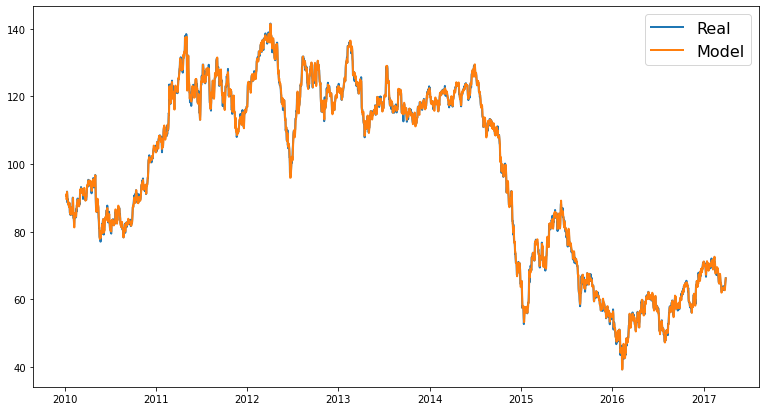

In [33]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(tra, label='Real', linewidth=2)
ax.plot(pred_train, label='Model', linewidth=2)
ax.legend(loc='best', fontsize=16)

In [ ]:
diff_modelReal = 

### Plot Test vs Pred

In [36]:
tesPlt = tes.copy()
tesPlt.index = tesPlt.index.to_timestamp()
predPlt = pred.copy()
predPlt.index = predPlt.index.to_timestamp()

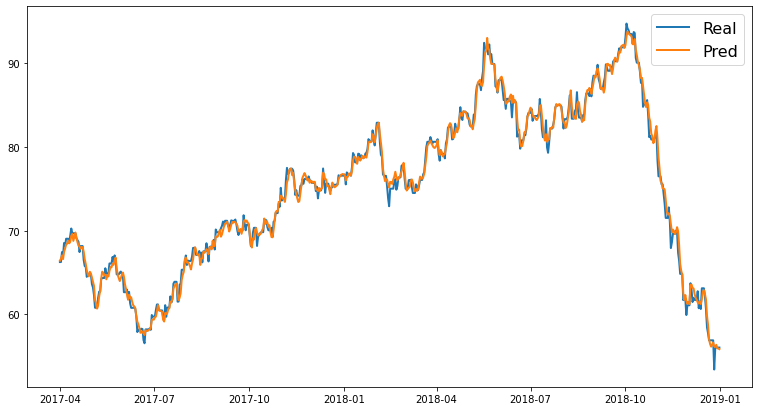

In [37]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(tesPlt, label='Real', linewidth=2)
ax.plot(predPlt, label='Pred', linewidth=2)
ax.legend(loc='best', fontsize=16)

### Output the model to a pickle file for comparison with other models

In [155]:
import pickle
path = "../Models/"
filename = "var.sav" #change according to your model name
filepath = path + filename
pickle.dump(model, open(filepath, 'wb'))